In [204]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# sklearn
from sklearn.model_selection import GroupKFold,StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#gensim
from gensim import models, corpora
import pyLDAvis.gensim

warnings.filterwarnings("ignore")

In [130]:
# load data and dictionary
df_plot = pd.read_csv('../../Data/clean_data_v3.csv',usecols=['Title','Cleaned_Plot'])
df_plot = df_plot[['Title','Cleaned_Plot']]
df_genre = pd.read_csv('../../Data/classification.csv',usecols=['Title','genre','genre_index'])
dictionary = corpora.Dictionary.load('recommendSys.dict')
df = pd.merge(df_genre,df_plot,how='inner',on='Title')

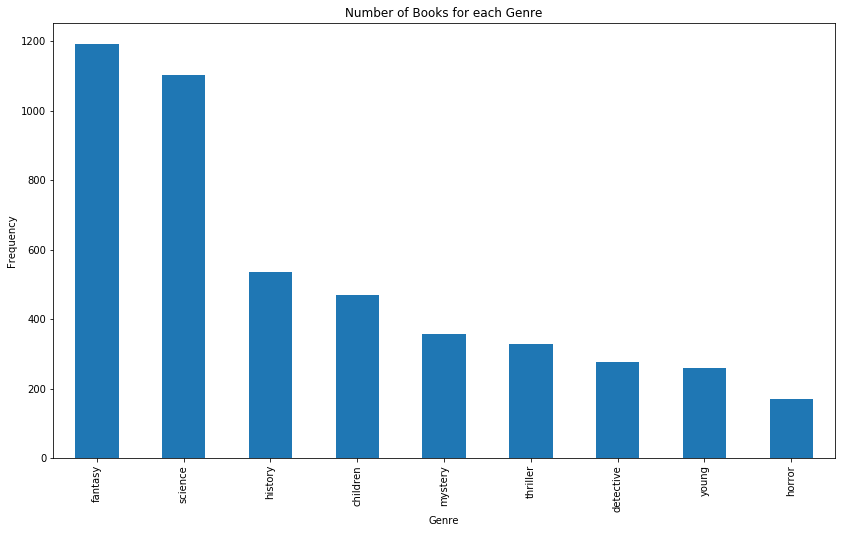

In [131]:
# vis for each category
ax = df['genre'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of Books for each Genre")
ax.set_xlabel("Genre")
ax.set_ylabel("Frequency")
plt.show()

In [179]:
# split training and testing set
def groupSplit(X,y,test_size=0.2,n_splits=1):
    
    split = StratifiedShuffleSplit(n_splits = n_splits, test_size = test_size,random_state = 0)
    for train_idx,test_idx in split.split(X,y):
        X_train,X_test = X[train_idx],X[test_idx]
        y_train,y_test = y[train_idx],y[test_idx]
    X_train.reset_index(inplace=True, drop=True)
    y_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)
    return X_train,y_train,X_test,y_test


X = df['Cleaned_Plot'].apply(lambda x:x.split())
y = df['genre']
X_train,y_train,X_test,y_test = groupSplit(X,y)
X_train,y_train,X_val,y_val = groupSplit(X_train,y_train)

In [193]:
# Data Preprocessing
def dataPreprocessing(X):
    '''
    Args:
        X: documents, each sample with a list of tokens

    Return:
        dictionary: index(key): words(values)
        corpus_tfidf: a list of documents which are represented by TF-IDF
    '''
    # create a dictionary, map index to words
    dictionary = corpora.Dictionary(X)
    
    # apply bag of words for input, here the index would represent for words
    corpus = [dictionary.doc2bow(text)for text in X]
    
    # apply if-idf model for corpus
    tfidf_model = models.TfidfModel(corpus,normalize=True)

    # represent the input with tf-idf
    corpus_tfidf = [tfidf_model[doc] for doc in corpus]
    
    return tfidf_model,dictionary, corpus_tfidf,corpus

# Apply TF-IDF model
tfidf_model, dictionary, X_train_tfidf,X_bow = dataPreprocessing(X_train)
X_val_bow = [dictionary.doc2bow(doc) for doc in X_val]
X_val_tfidf = [tfidf_model[doc] for doc in X_val_bow]
X_test_bow = [dictionary.doc2bow(doc) for doc in X_test]
X_test_tfidf = [tfidf_model[doc] for doc in X_test_bow]

In [205]:
# select number of topics for lsi
def topicsSelection(num_topics,X_train=X_train,X_train_tfidf=X_train_tfidf,y_train=y_train,\
                    X_test_tfidf=X_test_tfidf,\
                    y_test=y_test,dictionary=dictionary):
    
    train_accuracy = []
    test_accuracy = []
    for i in num_topics:
        # train lsi model
        lsi = models.LsiModel(X_train_tfidf,id2word = dictionary,num_topics = i)
        
        # get lsi topics
        X_train_lsi = []
        for doc in X_train_tfidf:
            topics = [topic[1] for topic in lsi[doc]]
            X_train_lsi.append(topics)
        
        X_test_lsi = []
        for doc in X_test_tfidf:
            topics = [topic[1] for topic in lsi[doc]]
            X_test_lsi.append(topics)
        
        model = LogisticRegression(solver = 'lbfgs')
        model.fit(X_train_lsi, y_train)
        
        # accuracy
        y_pred = model.predict(X_train_lsi)
        train_accuracy.append(metrics.accuracy_score(y_train, y_pred))
        
        y_pred = model.predict(X_test_lsi)
        test_accuracy.append(metrics.accuracy_score(y_test, y_pred))
        
    return train_accuracy,test_accuracy
    

In [222]:
num_topics = [i for i in range(5,101,5)]
train_accuracy,val_accuracy = topicsSelection(num_topics= num_topics,X_test_tfidf = X_val_tfidf,
                                              y_test=y_val)

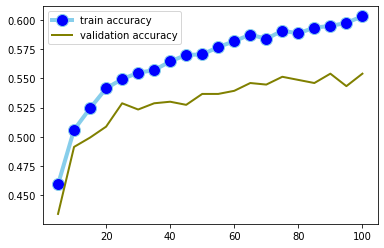

In [223]:
plt.plot(num_topics, train_accuracy, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label = 'train accuracy')
plt.plot(num_topics, val_accuracy,  marker='', color='olive', linewidth=2,label='validation accuracy')
plt.legend()

Here, we find the optimal number of topics is in the interval from 20 to 40. Then, we will perform a grid search in this interval.

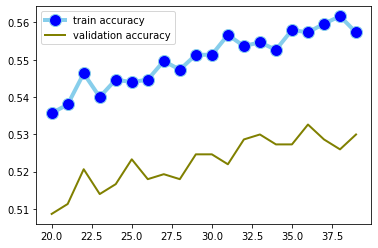

In [225]:
num_topics = [i for i in range(20,40)]
train_accuracy,val_accuracy = topicsSelection(num_topics= num_topics,X_test_tfidf = X_val_tfidf,
                                              y_test=y_val)
plt.plot(num_topics, train_accuracy, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label = 'train accuracy')
plt.plot(num_topics, val_accuracy,  marker='', color='olive', linewidth=2,label='validation accuracy')
plt.legend()

Here, we pick up 36 as our final number of topics for LSI model.

In [231]:
X_train_all = list(X_train_tfidf)+list(X_val_tfidf)
y_train_all = list(y_train)+list(y_val)
train_accuracy,test_accuracy = topicsSelection(num_topics= [36],X_train_tfidf=X_train_all,y_train=y_train_all,X_test_tfidf = X_test_tfidf,
                                            y_test=y_test)

In [235]:
print('The testing accuracy is: ', round(test_accuracy[0],3))

The testing accuracy is:  0.553
